<a href="https://colab.research.google.com/github/valmirf/redes_neurais_pos/blob/main/RBF/RBF_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural de Base Radial (RBF)

As redes RBF são redes de alimentação direta (feedforward) consistindo de três camadas:


1.   **Camada de entrada**: propaga os estímulos
2.   **Camada escondida**: Unidades de processamento localmente sintonizáveis, utilizando mapeamento não linear.
3.   **Camada de saída**: Unidades de processamento lineares.


****

**O treinamento dessa rede ocorre de forma híbrida**, combinando aprendizagem não supervisionada (ANS) com a supervisionada(AS). Isso ocorre, pois em geral não se sabe quais saídas se desejam para a camada escondida. Sendo assim, a distribuição de trabalhos ocorre:
*   **ANS**: Treina a camada escondida definindo seus parâmetros livres (centros, larguras dos campos receptivos e pesos).
*   **AS**: Determina os valores dos pesos entre as camadas escondidas e de saída, considerando constantes os parâmetros já definidos.


****

**O aprendizado consiste em** determinar os valores para:
*   centro das funções de base radial,
*   largura das funções,
*   pesos da camada de saída.


Além disso, para cada neurônio da camada escondida, ele computa uma função de base radial.


Os passos necessários são:
1.   Utilizar um algoritmo ANS para encontrar os centros (protótipo para um cluster) das RBF;
2.   Utilizar métodos heurísticos para determinar a largura (área de influência de um cluster) de cada função;
3.   Utilizar um AS para determinar os pesos da camada de saída da rede.

1ª Etapa: Inicialização dos grupos com K-Means

In [1]:
!git clone https://github.com/valmirf/redes_neurais_pos.git

fatal: destination path 'redes_neurais_pos' already exists and is not an empty directory.


Definição da função de base radial

In [2]:
import numpy as np

#função de base radial gaussiana
def rbfGaussiana(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

def rbfMultiquadratica(x, c, s):
    return np.sqrt((x-c)**2 + s**2)

#função de cálculo da largura do campo receptivo em que se repete o mesmo valor pra todos os neurônios
def computeEqualStds(centers,k):
  dist = [np.sqrt(np.sum((c1 - c2) ** 2)) for c1 in centers for c2 in centers]
  dMax = np.max(dist)
  stds = np.repeat(dMax / np.sqrt(2 * k), k)
  return stds

2ª Etapa - Treinamento de uma Rede Neural

In [3]:
from sklearn.cluster import KMeans

class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""

    def __init__(self, k=3, attnumber=4, lr=0.01, epochs=100, rbf=rbfGaussiana, computeStds=computeEqualStds):
        self.k = k  # grupos ou numero de neuronios na camada escondida
        self.lr = lr # taxa de aprendizagem
        self.epochs = epochs  # número de iterações
        self.rbf = rbf # função de base radial
        self.computeStds = computeStds  #função de cálculo da largura do campo receptivo

        self.w = np.random.randn(self.k,attnumber)
        self.b = np.random.randn(1)

    def fit(self, X, y):
        self.stds = []
        #K-Means pra pegar os centros inicias 
        #1º parâmetro da rede RBF
        kmeans = KMeans(
            n_clusters=self.k, init='random',
            n_init=10, max_iter=300).fit(X)
        self.centers = kmeans.cluster_centers_
        #print('centers: ', self.centers)
        
        #Cálculo la dargura do campo receptivo
        #2º parâmetro da rede RBF
        self.stds = self.computeStds(self.centers,self.k)
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                #calcula a saída de cada neurônio da função de base radial
                phi = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                #calcula somatório do produto da saída da função de base radial e os pesos
                F = phi.T.dot(self.w)
                F = np.sum(F) + self.b
                #saída da rede
                out = 0 if F < 0 else 1
                
                #função de perda 
                loss = (y[i] - out).flatten() ** 2
                #print('Loss: {0:.2f}'.format(loss[0]))

                #cálculo do erro
                error = (y[i] - out).flatten()
                #atualização dos pesos
                #3º Parâmetro da rede 
                self.w = self.w + self.lr * error * phi 
                self.b = self.b + self.lr * error

    #calcula saída da rede RBF com a rede treinada
    def predict(self, X):
        y_pred = []
        error = 0
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w)
            F = np.sum(F) + self.b
            out = 0 if F < 0 else 1
            y_pred.append(out)

        return np.array(y_pred)




```
# Isto está formatado como código
```

# Executando a rede neural RBF

In [4]:
# Neste código vou utilizar o pandas, framework amplamente utilizado pra lidar com dados
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import random

#carrega a base de dados e retorna conjuntos de treinamento e teste
def load_data():
    url = 'diabetes.csv'
    df = pd.read_csv(url)
    #remove a ultima coluna (dados)
    data = df[df.columns[:-1]]
    #normaliza os dados
    normalized_data = (data - data.min()) / (data.max() - data.min())
    #retorna a última coluna (rótulos)
    labels = df[df.columns[-1]]
    #separa em conjunto de treinamento e teste com seus respectivos rótulos
    X_train, X_test, y_train, y_test = train_test_split(normalized_data, labels, test_size=0.2, random_state=random.randint(0, 1000))
    
    return X_train, X_test, y_train, y_test

#chama função que carrega base de dados
training_inputs, test_inputs, training_labels, test_labels = load_data()

#transforma rótulos do conjunto de treinamento em numeros pra calculo do erro
le = preprocessing.LabelEncoder()
le.fit(training_labels.values)
training_labels_transformed = le.transform(training_labels.values)

#chama RBF
rbfnet = RBFNet(lr=1e-2, attnumber=8, k=3, computeStds=computeEqualStds)
rbfnet.fit(training_inputs.values, training_labels_transformed)

#transforma rótulos do conjunto de teste em numeros pra calculo do erro
le = preprocessing.LabelEncoder()
le.fit(test_labels.values)
test_labels_transformed = le.transform(test_labels.values)

y_pred = rbfnet.predict(test_inputs.values)

error = mean_squared_error(test_labels_transformed, y_pred)

print('error: ', error)

error:  0.2922077922077922


# Descrição Mini Projeto

Utilizando o código acima, modifique a última seção (Executando com Base de Dados) para que ele seja executado com a base de dados do arquivo diabetes.csv. Depois, modifique a função de base radial implementada (Gaussiana) para a Multiquadrática Inversa e calcule a taxa de erro.


1- Calcular a quantidade de neurônios escondidos:

a) 3

b) 5

c) 7

d) 9

Qual foi a melhor configuração? Avaliaria um outro valor?

2- Utilizando a melhor configuração da questão anterior, calcular a taxa de erro usando uma das outras maneiras de retorno da largura do campo receptivo da função de base radial, em que cada neurônio possui sua própria largura. 


3- Calcular a taxa de erro combinando 2 funções de Base Radial e as duas maneiras de cálculo da largura do campo receptivo:

a) Gaussiana

b) Multiquadrática Inversa


Qual foi a melhor configuração?



DATA DE ENTREGA: 09/09/2020


### 1. Calcular Taxa de Erros para a quantidade de neurônios escondidos

In [7]:
N_BENCHMARKS = 10

In [5]:
def benchmark(k:int, rbf):
    training_inputs, test_inputs, training_labels, test_labels = load_data()
    le = preprocessing.LabelEncoder()
    le.fit(training_labels.values)
    training_labels_transformed = le.transform(training_labels.values)
    rbfnet = RBFNet(lr=1e-2, attnumber=8, k=k, rbf=rbf,computeStds=computeEqualStds)
    rbfnet.fit(training_inputs.values, training_labels_transformed)
    
    le = preprocessing.LabelEncoder()
    le.fit(test_labels.values)
    test_labels_transformed = le.transform(test_labels.values)
    y_pred = rbfnet.predict(test_inputs.values)
    
    return mean_squared_error(test_labels_transformed, y_pred)

In [19]:
neurons = [3, 5, 7, 9]
errors_gauss = [[]]
errors_multiquad = [[]]

for n in neurons:
    for i in range(N_BENCHMARKS):
        error = benchmark(n, rbfGaussiana)
        errors_gauss.append(error)
        error = benchmark(n, rbfMultiquadratica)
        errors_multiquad.append(error)

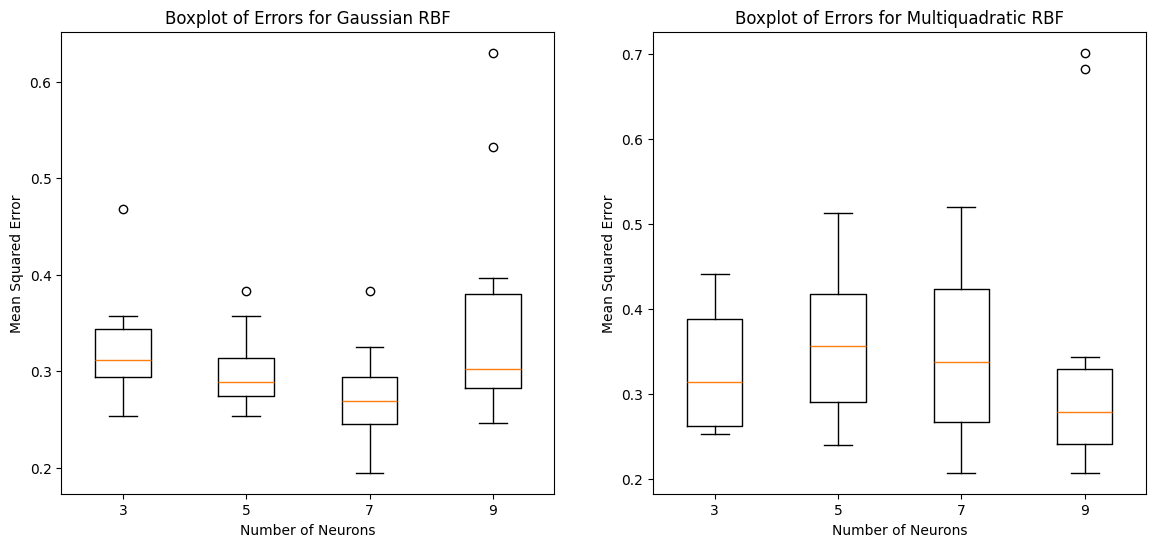

In [21]:
import matplotlib.pyplot as plt

# Organize errors by the number of neurons for both Gaussian and Multiquadratic
organized_errors_gauss = {n: [] for n in neurons}
organized_errors_multiquad = {n: [] for n in neurons}

index = 1
for n in neurons:
    for _ in range(N_BENCHMARKS):
        organized_errors_gauss[n].append(errors_gauss[index])
        organized_errors_multiquad[n].append(errors_multiquad[index])
        index += 1

# Draw a boxplot for the errors
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].boxplot([organized_errors_gauss[n] for n in neurons])
axes[0].set_xlabel('Number of Neurons')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('Boxplot of Errors for Gaussian RBF')
axes[0].set_xticks(range(1, len(neurons) + 1))
axes[0].set_xticklabels(neurons)

axes[1].boxplot([organized_errors_multiquad[n] for n in neurons])
axes[1].set_xlabel('Number of Neurons')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('Boxplot of Errors for Multiquadratic RBF')
axes[1].set_xticks(range(1, len(neurons) + 1))
axes[1].set_xticklabels(neurons)

plt.show()

De acordo com o benchmark, com 10 testes para cada configuração de neurônio, observamos uma tendência de aproximação para 7 ou 9 neurônios atingindo uma menor taxa de erro, tanto para Gaussiana, como para a multiquadrática. Assim, recomenda-se avaliar o valor com 8 neurônios; visto que, ao observar o benchmark existe uma conversão entre 7 ou 9 para uma menor taxa de erro.

### 2. Calcular Taxa de Erro com forma de calcular largura de campo, em que cada neurônio possui própria largura

In [22]:
# Função para calcular a largura do campo receptivo individualmente para cada neurônio
def computeIndividualStds(centers, k):
    stds = []
    for i in range(k):
        dist = [np.sqrt(np.sum((centers[i] - c) ** 2)) for c in centers]
        stds.append(np.max(dist) / np.sqrt(2 * k))
    return np.array(stds)


In [23]:
# Benchmark com a nova função de cálculo da largura do campo receptivo
def benchmark(k, rbf, computeStds):
    training_inputs, test_inputs, training_labels, test_labels = load_data()
    le = preprocessing.LabelEncoder()
    le.fit(training_labels.values)
    training_labels_transformed = le.transform(training_labels.values)
    rbfnet = RBFNet(lr=1e-2, attnumber=8, k=k, rbf=rbf, computeStds=computeStds)
    rbfnet.fit(training_inputs.values, training_labels_transformed)
    
    le = preprocessing.LabelEncoder()
    le.fit(test_labels.values)
    test_labels_transformed = le.transform(test_labels.values)
    y_pred = rbfnet.predict(test_inputs.values)
    
    return mean_squared_error(test_labels_transformed, y_pred)

In [24]:
# Executar o benchmark para a melhor configuração de neurônios
best_neurons = 7  

benchmark(best_neurons, rbfGaussiana, computeIndividualStds)

np.float64(0.36363636363636365)

## 3. Calcular a taxa de erro combinando 2 funções de Base Radial e as duas maneiras de cálculo da largura do campo receptivo

In [ ]:
N_BENCHMARKS = 10

neurons = [7, 8, 9]
errors_gauss_equal = [[]]
errors_gauss_indiv = [[]]
errors_multi_equal = [[]]
errors_multi_indiv = [[]]

In [28]:
# Run benchmarks for different configurations
for n in neurons:
    for i in range(N_BENCHMARKS):
        error = benchmark(n, rbfGaussiana, computeEqualStds)
        errors_gauss_equal.append(error)
        error = benchmark(n, rbfGaussiana, computeIndividualStds)
        errors_gauss_indiv.append(error)
        error = benchmark(n, rbfMultiquadratica, computeEqualStds)
        errors_multi_equal.append(error)
        error = benchmark(n, rbfMultiquadratica, computeIndividualStds)
        errors_multi_indiv.append(error)

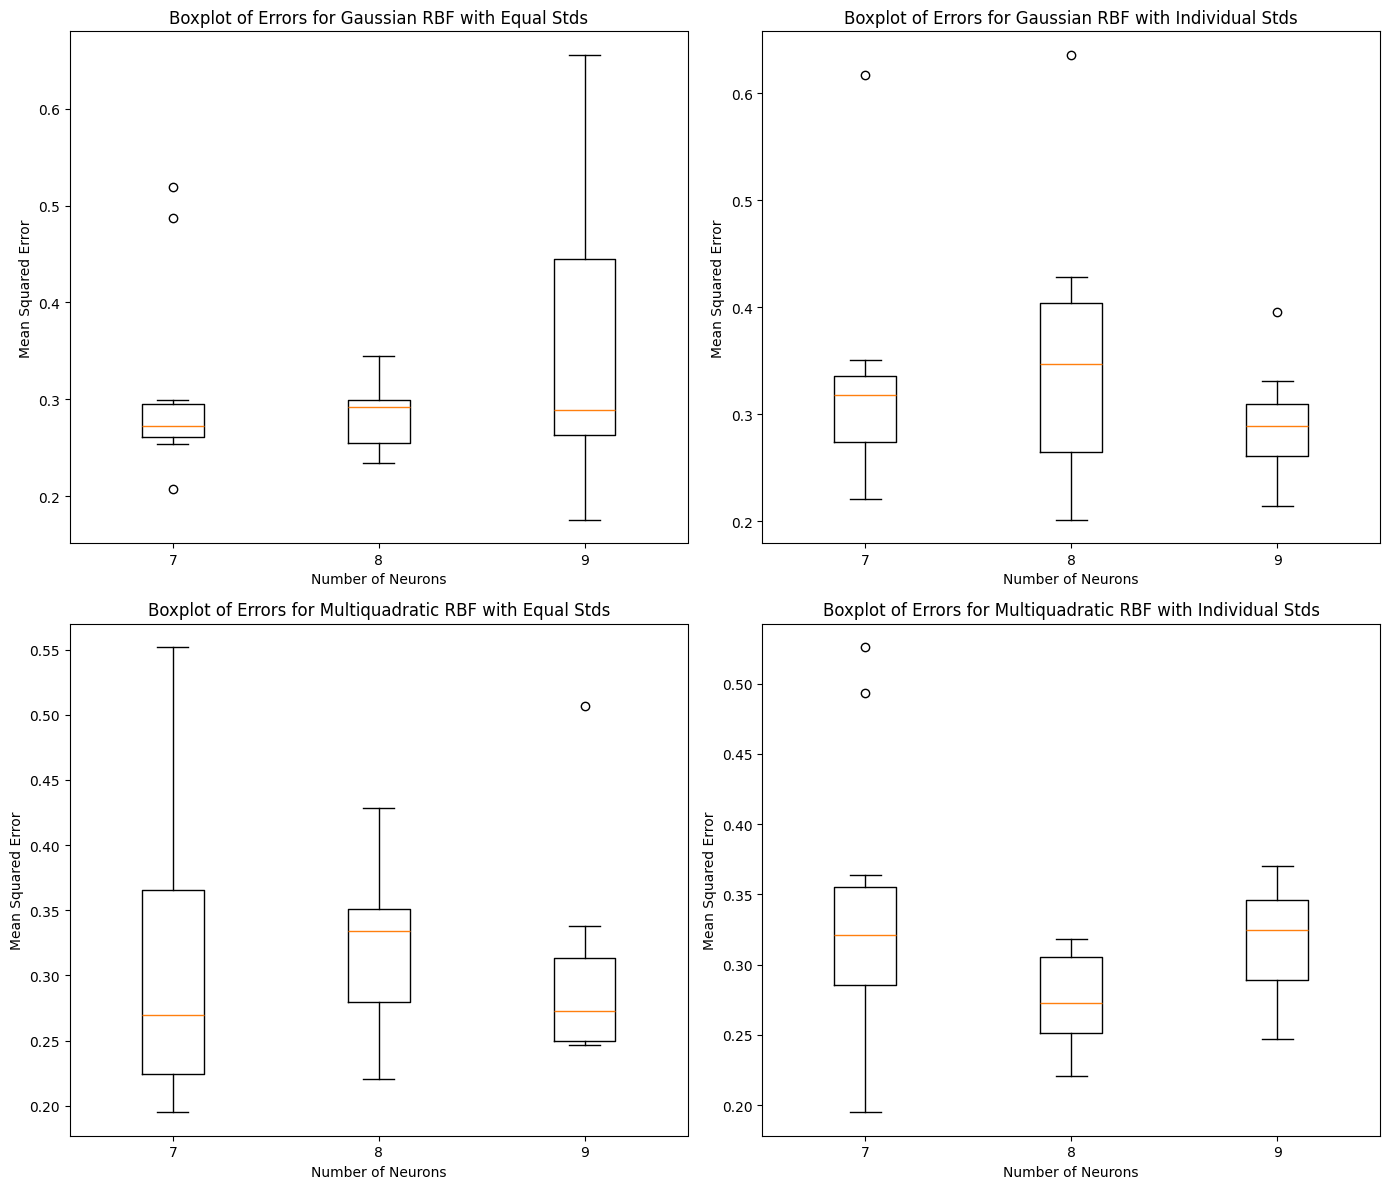

In [29]:
import matplotlib.pyplot as plt

# Organize errors by the number of neurons for all configurations
organized_errors_gauss_equal = {n: [] for n in neurons}
organized_errors_gauss_indiv = {n: [] for n in neurons}
organized_errors_multi_equal = {n: [] for n in neurons}
organized_errors_multi_indiv = {n: [] for n in neurons}

index = 1
for n in neurons:
    for _ in range(N_BENCHMARKS):
        organized_errors_gauss_equal[n].append(errors_gauss_equal[index])
        organized_errors_gauss_indiv[n].append(errors_gauss_indiv[index])
        organized_errors_multi_equal[n].append(errors_multi_equal[index])
        organized_errors_multi_indiv[n].append(errors_multi_indiv[index])
        index += 1

# Draw a boxplot for the errors
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].boxplot([organized_errors_gauss_equal[n] for n in neurons])
axes[0, 0].set_xlabel('Number of Neurons')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].set_title('Boxplot of Errors for Gaussian RBF with Equal Stds')
axes[0, 0].set_xticks(range(1, len(neurons) + 1))
axes[0, 0].set_xticklabels(neurons)

axes[0, 1].boxplot([organized_errors_gauss_indiv[n] for n in neurons])
axes[0, 1].set_xlabel('Number of Neurons')
axes[0, 1].set_ylabel('Mean Squared Error')
axes[0, 1].set_title('Boxplot of Errors for Gaussian RBF with Individual Stds')
axes[0, 1].set_xticks(range(1, len(neurons) + 1))
axes[0, 1].set_xticklabels(neurons)

axes[1, 0].boxplot([organized_errors_multi_equal[n] for n in neurons])
axes[1, 0].set_xlabel('Number of Neurons')
axes[1, 0].set_ylabel('Mean Squared Error')
axes[1, 0].set_title('Boxplot of Errors for Multiquadratic RBF with Equal Stds')
axes[1, 0].set_xticks(range(1, len(neurons) + 1))
axes[1, 0].set_xticklabels(neurons)

axes[1, 1].boxplot([organized_errors_multi_indiv[n] for n in neurons])
axes[1, 1].set_xlabel('Number of Neurons')
axes[1, 1].set_ylabel('Mean Squared Error')
axes[1, 1].set_title('Boxplot of Errors for Multiquadratic RBF with Individual Stds')
axes[1, 1].set_xticks(range(1, len(neurons) + 1))
axes[1, 1].set_xticklabels(neurons)

plt.tight_layout()
plt.show()

Nesse sentido, podemos observar nos melhores treinamentos, que a configuração com RBF com base multiquadrática, com resultado similares entre largura de campo igual ou individual, alcançando valores abaixo do limiar de 20% de taxa de erro quadrático. Quanto ao número de neurônios, observamos que apenas com 7 neurônios é possível alcançar o limiar dos 20%. Porém ao aumentar o valor de neurônios observamos treinamentos com predições mais estáveis, porém incapaz de alcançar taxas de erros mais sastifatórias (isso é observado para base multiquadrática).